## 1. Setup and Configuration

In [1]:
# ==================================================
# PERFORMANCE ANALYSIS PIPELINE (TOTAL POINTS & TOP SCORER)
# ==================================================

# Cell 1: Setup and Configuration
# ==================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from pathlib import Path
import warnings
import os
from datetime import datetime

# Sklearn imports
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# XGBoost and LightGBM
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False

try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
except ImportError:
    LGB_AVAILABLE = False

# Configuration
os.chdir('d:\\ScoreSight')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

# Paths
MODELS_DIR = Path('models')
VIZ_DIR = Path('visualizations/performance_analysis')
DATASETS_DIR = Path('datasets')

RAW_LEAGUE_DATA_PATH = DATASETS_DIR / 'ScoreSight_ML_Season_LeagueWinner_Champion.csv'
RAW_PLAYER_DATA_PATH = DATASETS_DIR / 'Goals & Assist.xlsx'

POINTS_DATA_PATH = Path('data/points_tally/points_tally_data.csv')
SCORER_DATA_PATH = Path('data/top_scorer/top_scorer_data.csv')
REPORTS_DIR = Path('reports/performance_analysis')

for dir_path in [MODELS_DIR, VIZ_DIR, POINTS_DATA_PATH.parent, 
                 SCORER_DATA_PATH.parent, REPORTS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42

print("="*80)
print("PERFORMANCE ANALYSIS PIPELINE")
print("Part 1: Total Points Prediction")
print("Part 2: Top Scorer Prediction")
print("="*80)
print(f"Setup completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"XGBoost Available: {XGB_AVAILABLE}")
print(f"LightGBM Available: {LGB_AVAILABLE}")
print("="*80)

PERFORMANCE ANALYSIS PIPELINE
Part 1: Total Points Prediction
Part 2: Top Scorer Prediction
Setup completed at: 2025-11-19 02:41:48
XGBoost Available: True
LightGBM Available: True


## 2. Total Points Prediction

### 2.1. Data Loading and Engineering (Total Points)

PART 1: TOTAL POINTS PREDICTION

Loading league data from: datasets\ScoreSight_ML_Season_LeagueWinner_Champion.csv
Removed 0 duplicate rows.

--- Column Analysis (Total Points) ---
Target Column: target_total_points
Excluded columns remove final outcomes (points, ranks) to guard against leakage.
Candidate numeric features (6): ['matches_played', 'goals_scored', 'goals_conceded', 'target_top_4', 'target_top_6', 'target_relegated']

No missing values detected across candidate features and target.


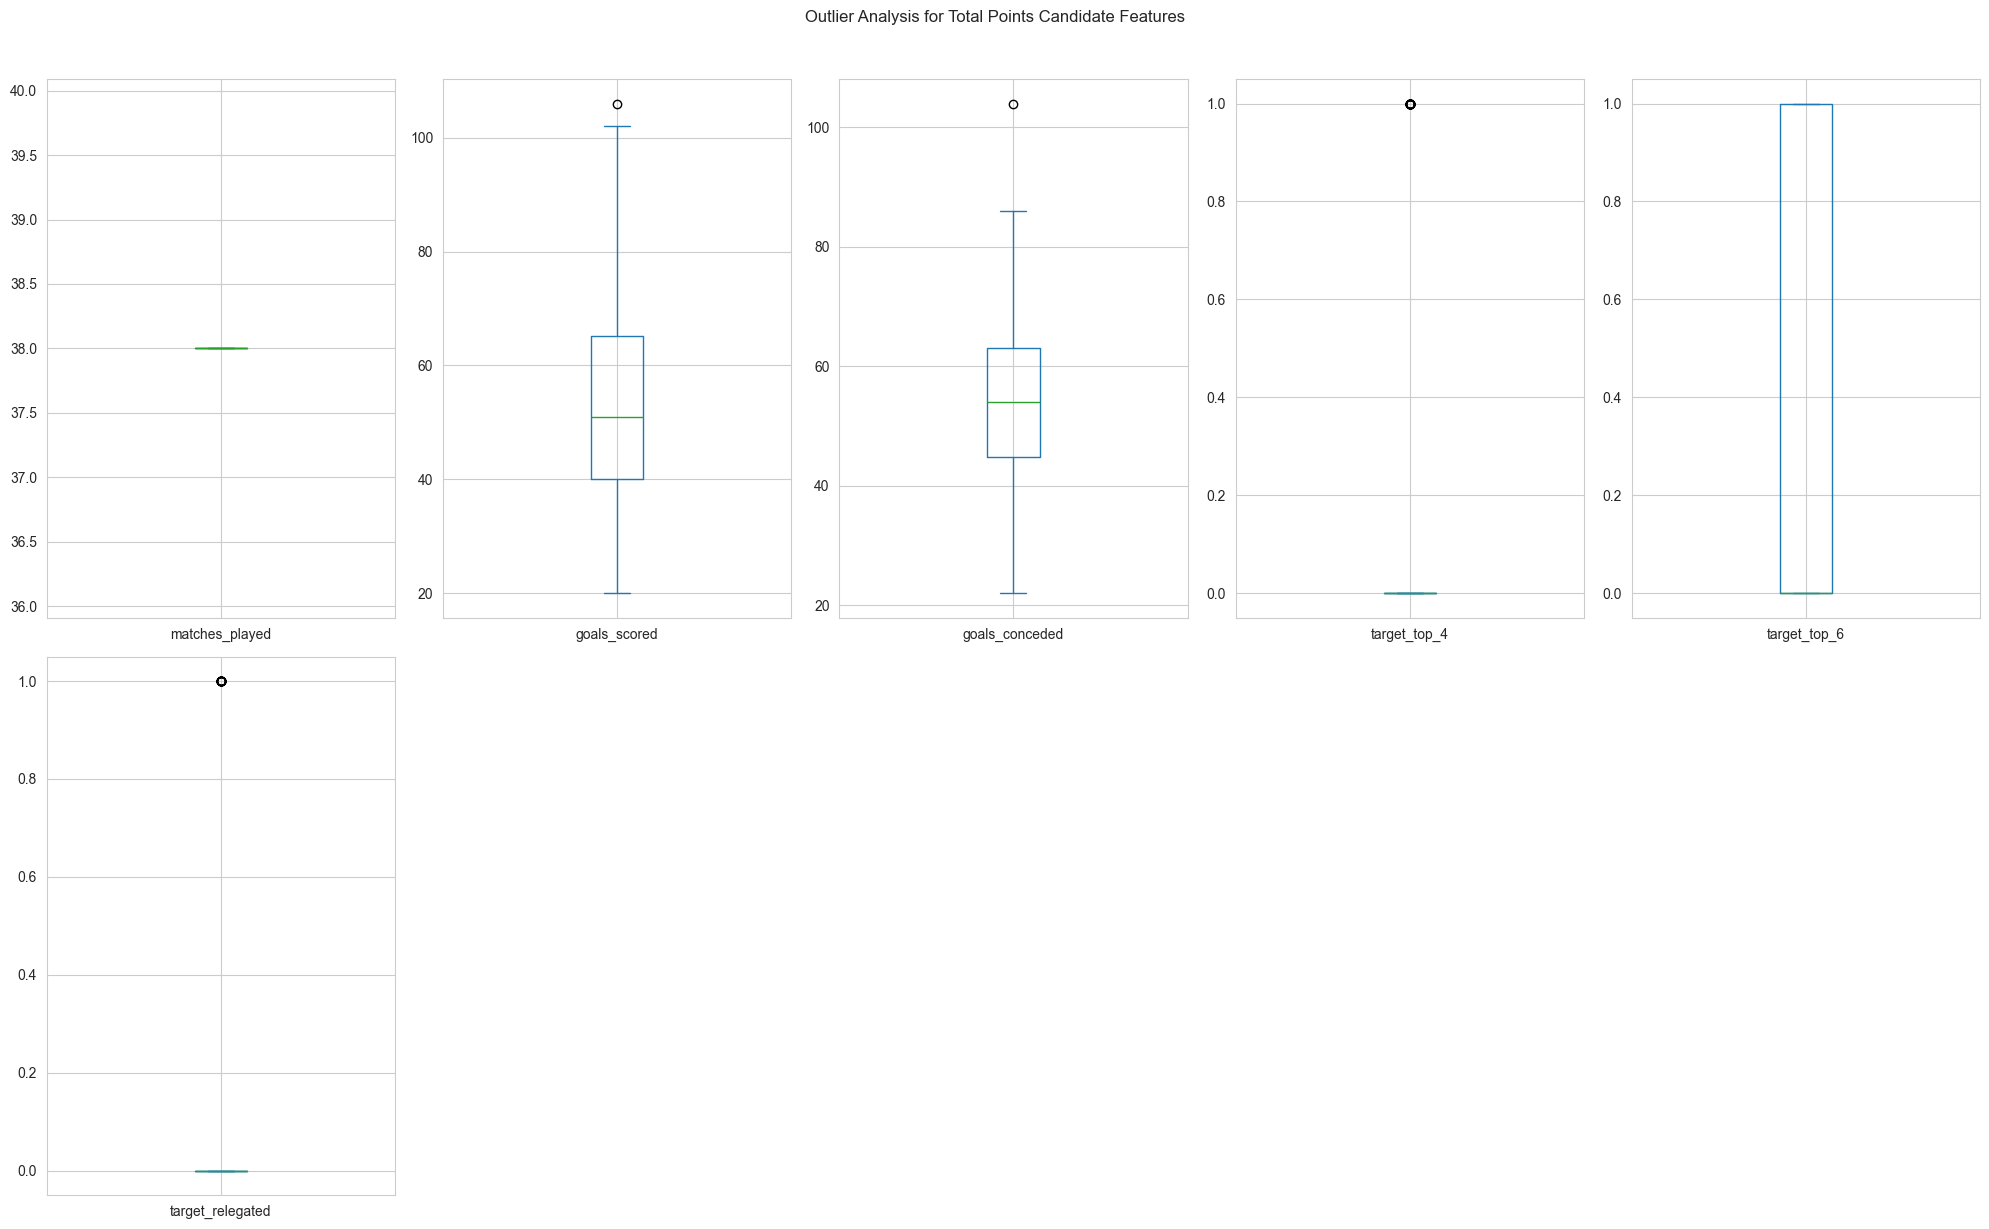

Outlier visualization saved to visualizations\performance_analysis\total_points_outlier_boxplots.png
Rows retained after dropping NaNs for feature selection: 180/180

Selected Top 6 Features for Total Points:
['matches_played', 'goals_scored', 'goals_conceded', 'target_top_4', 'target_top_6', 'target_relegated']
Final engineered data shape: (180, 8) | Remaining null cells: 0
Engineered points data saved to: data\points_tally\points_tally_data.csv


In [2]:
# ==================================================
# Cell 2: Data Loading, EDA, and Engineering (Total Points)
# ==================================================
print("="*50 + "\nPART 1: TOTAL POINTS PREDICTION\n" + "="*50)
print(f"\nLoading league data from: {RAW_LEAGUE_DATA_PATH}")
try:
    df_league_raw = pd.read_csv(RAW_LEAGUE_DATA_PATH)
    df_league_raw.columns = df_league_raw.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')
    before_dupes = df_league_raw.shape[0]
    df_league_raw.drop_duplicates(inplace=True)
    print(f"Removed {before_dupes - df_league_raw.shape[0]} duplicate rows.")
    
    TARGET_COL_POINTS = 'target_total_points'
    EXCLUDE_COLS = [
        'team', 'season_encoded', 'team_encoded', 'target_champion',
        'points_per_game', 'target_league_position', 'wins', 'draws', 'losses', 'points',
        'goal_difference', TARGET_COL_POINTS
    ]
    
    initial_features = [c for c in df_league_raw.columns if df_league_raw[c].dtype in ['float64', 'int64']]
    candidate_features = [c for c in initial_features if c not in EXCLUDE_COLS]
    
    print("\n--- Column Analysis (Total Points) ---")
    print(f"Target Column: {TARGET_COL_POINTS}")
    print("Excluded columns remove final outcomes (points, ranks) to guard against leakage.")
    print(f"Candidate numeric features ({len(candidate_features)}): {candidate_features}")
    
    null_summary = df_league_raw[candidate_features + [TARGET_COL_POINTS]].isnull().sum()
    missing_cols = null_summary[null_summary > 0]
    if not missing_cols.empty:
        print("\nMissing values detected before engineering:")
        print(missing_cols.sort_values(ascending=False))
    else:
        print("\nNo missing values detected across candidate features and target.")
    
    df_league_raw[candidate_features].plot(kind='box', subplots=True, layout=(-1, 5), figsize=(20, 12), title='Outlier Analysis (Total Points Features)')
    plt.suptitle("Outlier Analysis for Total Points Candidate Features", y=1.02)
    plt.tight_layout()
    tp_box_path = VIZ_DIR / 'total_points_outlier_boxplots.png'
    plt.savefig(tp_box_path)
    plt.show()
    print(f"Outlier visualization saved to {tp_box_path}")
    
    temp_df = df_league_raw[candidate_features + [TARGET_COL_POINTS]].dropna()
    rows_after_drop = temp_df.shape[0]
    print(f"Rows retained after dropping NaNs for feature selection: {rows_after_drop}/{df_league_raw.shape[0]}")
    selector = SelectKBest(f_regression, k=min(7, len(candidate_features)))
    selector.fit(temp_df[candidate_features], temp_df[TARGET_COL_POINTS])
    selected_features = list(temp_df[candidate_features].columns[selector.get_support()])
    
    print(f"\nSelected Top {len(selected_features)} Features for Total Points:\n{selected_features}")
    
    df_points = df_league_raw[selected_features + [TARGET_COL_POINTS, 'season']].copy()
    df_points.rename(columns={TARGET_COL_POINTS: 'total_points'}, inplace=True)
    remaining_nulls = int(df_points.isnull().sum().sum())
    print(f"Final engineered data shape: {df_points.shape} | Remaining null cells: {remaining_nulls}")
    if remaining_nulls > 0:
        print("Residual gaps will be handled via SimpleImputer during model training.")
    df_points.to_csv(POINTS_DATA_PATH, index=False)
    print(f"Engineered points data saved to: {POINTS_DATA_PATH}")
except FileNotFoundError:
    print(f"ERROR: File not found at {RAW_LEAGUE_DATA_PATH}")
    df_points = None
except Exception as e:
    print(f"An error occurred: {e}")
    df_points = None

### 2.2. Model Training (Total Points)


Training Total Points model with 6 features: ['matches_played', 'goals_scored', 'goals_conceded', 'target_top_4', 'target_top_6', 'target_relegated']
Missing cells at training time (handled via SimpleImputer): 0
Temporal split -> Train seasons: ['2015-16', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24'] | Hold-out season: 2024-25
--- Training Ridge for Total Points ---
  Test MAE: 3.2175 | Test R-squared: 0.9377
--- Training RandomForest for Total Points ---
  Test MAE: 3.2175 | Test R-squared: 0.9377
--- Training RandomForest for Total Points ---
  Test MAE: 3.8322 | Test R-squared: 0.9134
--- Training XGBoost for Total Points ---
  Test MAE: 3.8322 | Test R-squared: 0.9134
--- Training XGBoost for Total Points ---
  Test MAE: 3.7391 | Test R-squared: 0.9013
--- Training LightGBM for Total Points ---
  Test MAE: 3.7391 | Test R-squared: 0.9013
--- Training LightGBM for Total Points ---
  Test MAE: 4.1194 | Test R-squared: 0.9034

--- Total Points Model Tr

,Model,Test MAE,Test MSE,Test R-squared
0,Ridge,3.217526,20.412686,0.937733
2,XGBoost,3.739139,32.353188,0.901310
1,RandomForest,3.832164,28.377445,0.913438
3,LightGBM,4.119412,31.681347,0.903360



--- Best Model Analysis: Ridge ---


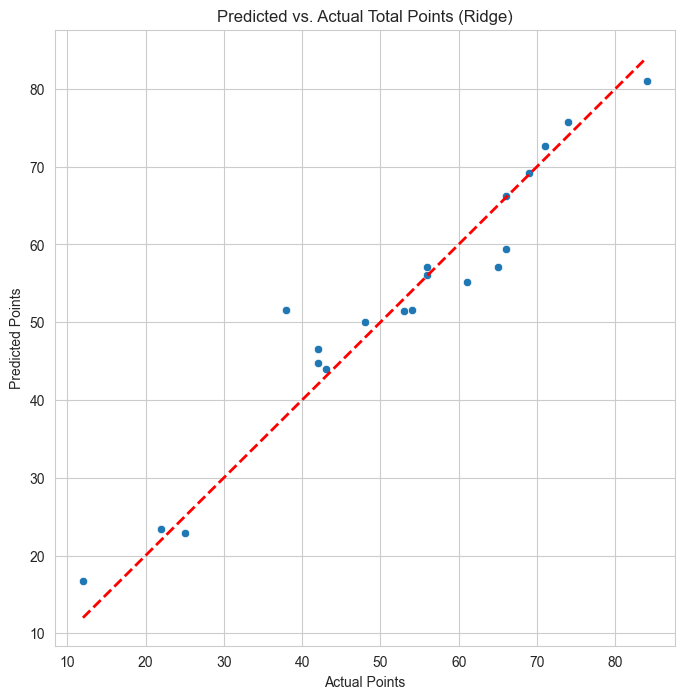

Prediction plot saved to visualizations\performance_analysis\total_points_pred_vs_actual.png

Total Points model and metadata saved.


In [3]:
# ==================================================
# Cell 3: Model Training and Evaluation (Total Points)
# ==================================================
if df_points is not None:
    TARGET_COL = 'total_points'
    features = [c for c in df_points.columns if c not in [TARGET_COL, 'season']]
    X = df_points[features]
    y = df_points[TARGET_COL]
    
    print(f"\nTraining Total Points model with {len(features)} features: {features}")
    print(f"Missing cells at training time (handled via SimpleImputer): {int(X.isnull().sum().sum())}")
    
    seasons = sorted(df_points['season'].unique())
    train_seasons, test_season = seasons[:-1], seasons[-1]
    print(f"Temporal split -> Train seasons: {train_seasons} | Hold-out season: {test_season}")
    X_train, y_train = X[df_points['season'].isin(train_seasons)], y[df_points['season'].isin(train_seasons)]
    X_test, y_test = X[df_points['season'] == test_season], y[df_points['season'] == test_season]
    
    models = {'Ridge': Ridge(random_state=42), 'RandomForest': RandomForestRegressor(random_state=42)}
    if XGB_AVAILABLE: models['XGBoost'] = xgb.XGBRegressor(random_state=42)
    if LGB_AVAILABLE: models['LightGBM'] = lgb.LGBMRegressor(random_state=42, verbose=-1)
    
    param_grids = {
        'Ridge': {'model__alpha': [1.0, 10.0, 50.0]},
        'RandomForest': {'model__n_estimators': [100, 200], 'model__max_depth': [10, 20]},
        'XGBoost': {'model__n_estimators': [100, 200], 'model__learning_rate': [0.05, 0.1]},
        'LightGBM': {'model__n_estimators': [100, 200], 'model__num_leaves': [20, 31]}
    }
    
    training_summary = []
    best_model_data = None
    best_mae = float('inf')
    
    for name, model in models.items():
        print(f"--- Training {name} for Total Points ---")
        pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler()), ('model', model)])
        search = RandomizedSearchCV(pipeline, param_grids[name], n_iter=5, cv=TimeSeriesSplit(5), scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42)
        search.fit(X_train, y_train)
        y_pred = search.predict(X_test)
        
        stats = {
            'Model': name,
            'Test MAE': mean_absolute_error(y_test, y_pred),
            'Test MSE': mean_squared_error(y_test, y_pred),
            'Test R-squared': r2_score(y_test, y_pred)
        }
        training_summary.append(stats)
        print(f"  Test MAE: {stats['Test MAE']:.4f} | Test R-squared: {stats['Test R-squared']:.4f}")
        
        if stats['Test MAE'] < best_mae:
            best_mae = stats['Test MAE']
            best_model_data = {'name': name, 'model': search.best_estimator_, 'metrics': stats, 'predictions': y_pred}
    
    summary_df = pd.DataFrame(training_summary)
    print("\n--- Total Points Model Training Summary ---")
    display(summary_df.sort_values(by='Test MAE'))
    
    print(f"\n--- Best Model Analysis: {best_model_data['name']} ---")
    
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_test, y=best_model_data['predictions'])
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f'Predicted vs. Actual Total Points ({best_model_data["name"]})')
    plt.xlabel('Actual Points')
    plt.ylabel('Predicted Points')
    viz_path = VIZ_DIR / 'total_points_pred_vs_actual.png'
    plt.savefig(viz_path)
    plt.show()
    print(f"Prediction plot saved to {viz_path}")
    
    best_model_step = best_model_data['model'].named_steps['model']
    if hasattr(best_model_step, 'feature_importances_'):
        importances = best_model_step.feature_importances_
        feature_imp_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending=False)
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_imp_df)
        plt.title(f'Feature Importance for {best_model_data["name"]}')
        fi_path = VIZ_DIR / 'total_points_feature_importance.png'
        plt.savefig(fi_path)
        plt.show()
        print(f"Feature importance plot saved to {fi_path}")
    
    joblib.dump(best_model_data['model'], MODELS_DIR / 'ps3_total_points_best_model.joblib')
    with open(MODELS_DIR / 'ps3_total_points_metadata.json', 'w') as f:
        json.dump({k: v for k, v in best_model_data.items() if k not in ['model', 'predictions']}, f, indent=2)
    print("\nTotal Points model and metadata saved.")
else:
    print("Skipping Total Points training.")

## 3. Top Scorer Prediction

### 3.1. Data Loading and Engineering (Top Scorer)


PART 2: TOP SCORER PREDICTION

Loading player data from: datasets\Goals & Assist.xlsx
Removed 0 duplicate rows.

--- Column Analysis (Top Scorer) ---
Target Column: goals
Candidate numeric features (23): ['unnamed:_0', 'age', 'matches_played', 'starts', 'minutes', '90s_played', 'assists', 'goals_+_assists', 'penalty_attempts', 'yellow_cards', 'red_cards', 'xg', 'npxg', 'xag', 'progressive_carries', 'progressive_passes', 'progressive_receives', 'non_penalty_goals_per_90', 'non_penalty_goals_+_assists_per_90', 'xg_per_90', 'xag_per_90', 'xg_+_xag_per_90', 'npxg_+_xag_per_90']
Removed 0 duplicate rows.

--- Column Analysis (Top Scorer) ---
Target Column: goals
Candidate numeric features (23): ['unnamed:_0', 'age', 'matches_played', 'starts', 'minutes', '90s_played', 'assists', 'goals_+_assists', 'penalty_attempts', 'yellow_cards', 'red_cards', 'xg', 'npxg', 'xag', 'progressive_carries', 'progressive_passes', 'progressive_receives', 'non_penalty_goals_per_90', 'non_penalty_goals_+_assists

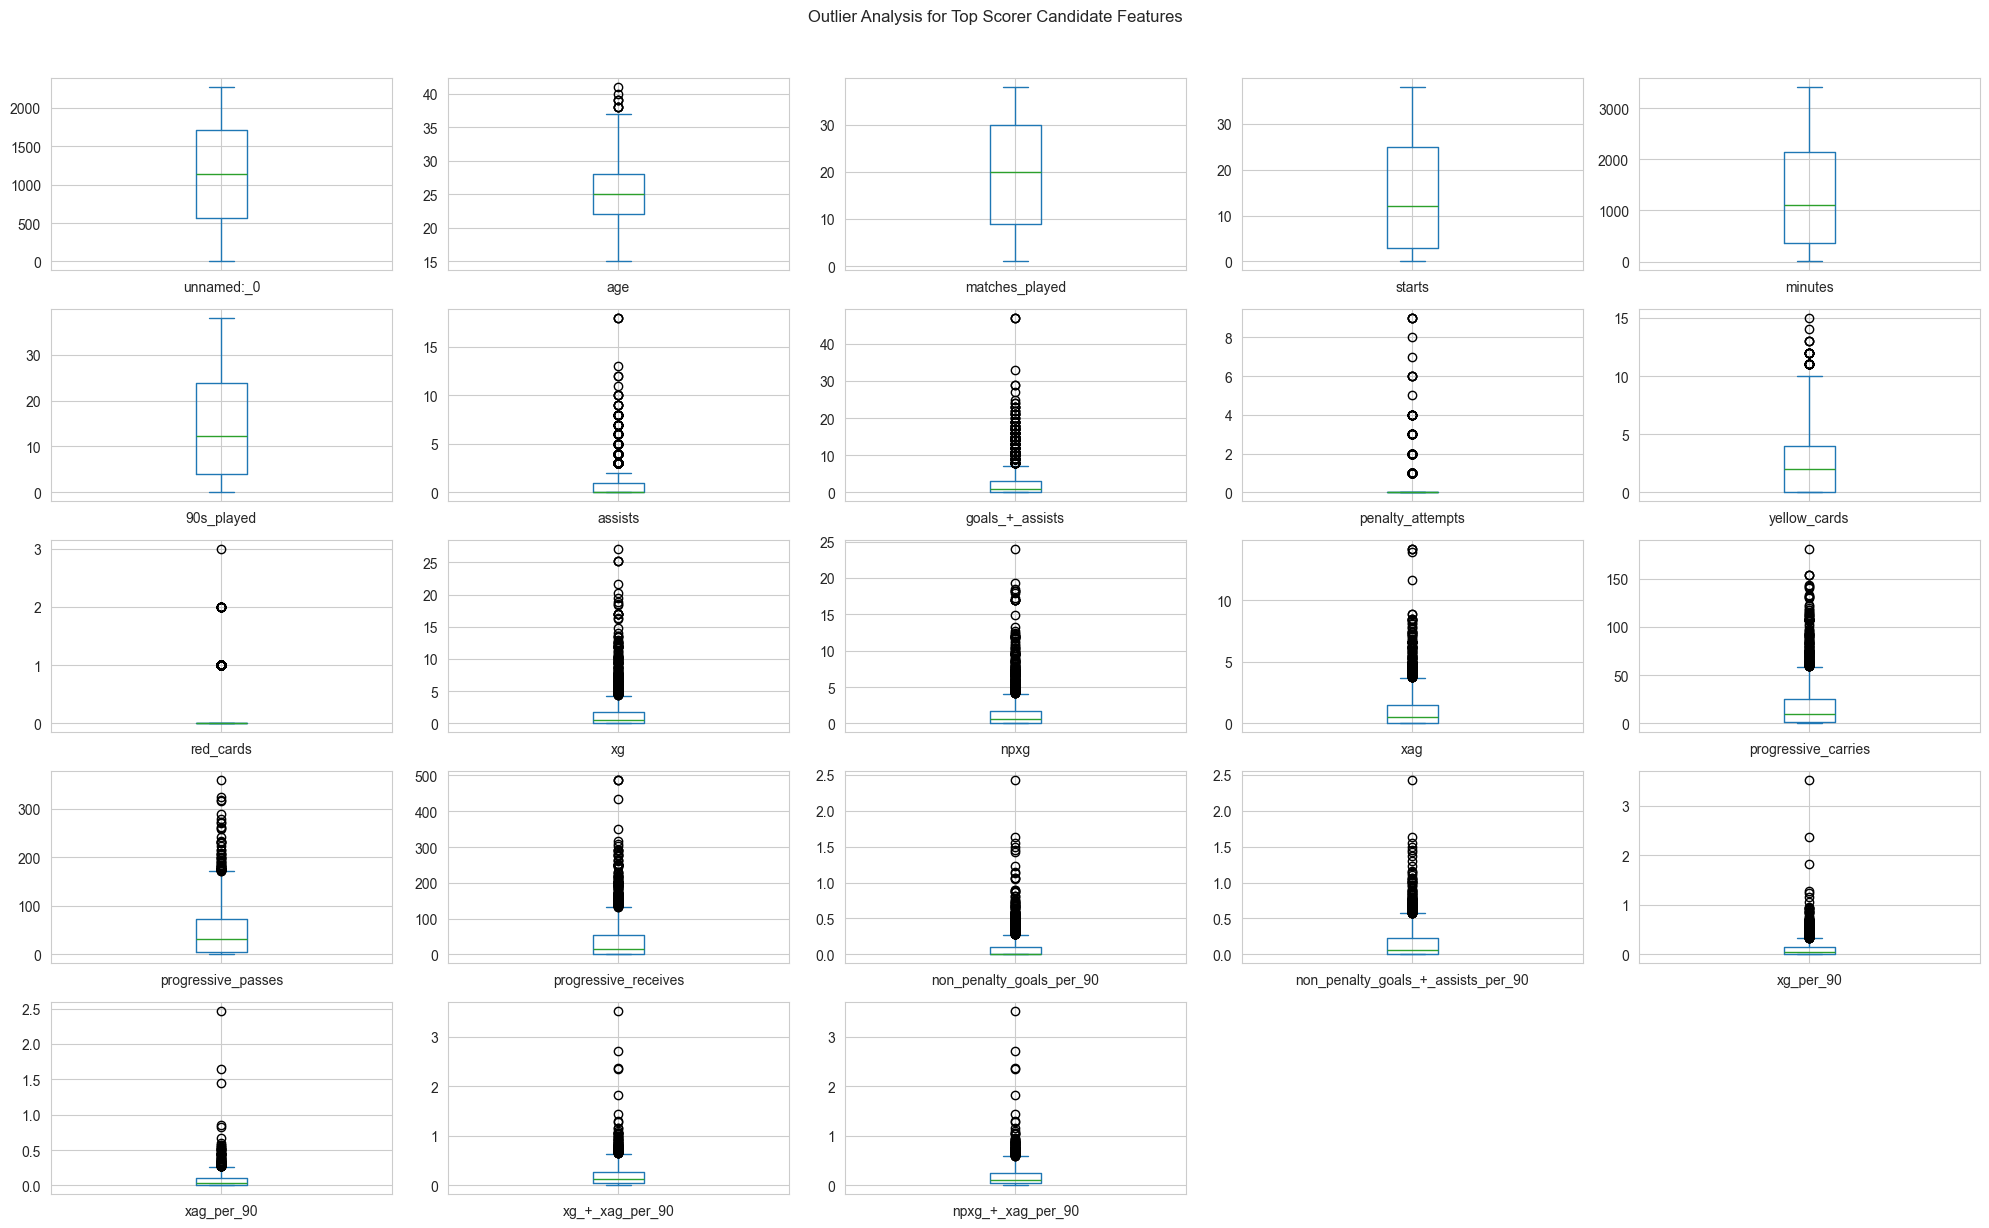

Outlier visualization saved to visualizations\performance_analysis\top_scorer_outlier_boxplots.png
Rows retained after dropping NaNs for feature selection: 2274/2274

Selected Top 7 Features for Top Scorer:
['goals_+_assists', 'penalty_attempts', 'xg', 'npxg', 'progressive_receives', 'non_penalty_goals_per_90', 'non_penalty_goals_+_assists_per_90']
Final scorer dataset shape: (2274, 8) | Remaining null cells: 0

Engineered scorer data saved to: data\top_scorer\top_scorer_data.csv


In [4]:
# ==================================================
# Cell 4: Data Loading, EDA, and Engineering (Top Scorer)
# ==================================================
print("\n" + "="*50 + "\nPART 2: TOP SCORER PREDICTION\n" + "="*50)
print(f"\nLoading player data from: {RAW_PLAYER_DATA_PATH}")
try:
    df_player_raw = pd.read_excel(RAW_PLAYER_DATA_PATH)
    df_player_raw.columns = df_player_raw.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')
    before_dupes = df_player_raw.shape[0]
    df_player_raw.drop_duplicates(inplace=True)
    print(f"Removed {before_dupes - df_player_raw.shape[0]} duplicate rows.")
    
    numeric_cols = df_player_raw.select_dtypes(include=np.number).columns
    numeric_nulls = df_player_raw[numeric_cols].isnull().sum()
    if numeric_nulls.any():
        print("Numeric columns with missing values (filled using median):")
        print(numeric_nulls[numeric_nulls > 0].sort_values(ascending=False))
    for col in numeric_cols:
        df_player_raw[col].fillna(df_player_raw[col].median(), inplace=True)
    
    TARGET_COL_SCORER = 'goals'
    EXCLUDE_COLS = [
        'player', 'team', 'season', 'nationality', 'position', 'player_encoded', 'nation_encoded', 'position_encoded',
        TARGET_COL_SCORER, 'non_penalty_goals', 'penalty_goals_made', 'npxg_+_xag',
        'goals_per_90', 'assists_per_90', 'goals_+_assists_per_90', 'npg_per_90', 'npxg_per_90'
    ]
    
    initial_features = [c for c in df_player_raw.columns if df_player_raw[c].dtype in ['float64', 'int64']]
    candidate_features = [c for c in initial_features if c not in EXCLUDE_COLS]
    
    print("\n--- Column Analysis (Top Scorer) ---")
    print(f"Target Column: {TARGET_COL_SCORER}")
    print(f"Candidate numeric features ({len(candidate_features)}): {candidate_features}")
    
    df_player_raw[candidate_features].plot(kind='box', subplots=True, layout=(-1, 5), figsize=(20, 12), title='Outlier Analysis (Top Scorer Features)')
    plt.suptitle("Outlier Analysis for Top Scorer Candidate Features", y=1.02)
    plt.tight_layout()
    ts_box_path = VIZ_DIR / 'top_scorer_outlier_boxplots.png'
    plt.savefig(ts_box_path)
    plt.show()
    print(f"Outlier visualization saved to {ts_box_path}")
    
    temp_df = df_player_raw[candidate_features + [TARGET_COL_SCORER]].dropna()
    print(f"Rows retained after dropping NaNs for feature selection: {temp_df.shape[0]}/{df_player_raw.shape[0]}")
    selector = SelectKBest(f_regression, k=min(7, len(candidate_features)))
    selector.fit(temp_df[candidate_features], temp_df[TARGET_COL_SCORER])
    selected_features = list(temp_df[candidate_features].columns[selector.get_support()])
    
    print(f"\nSelected Top {len(selected_features)} Features for Top Scorer:\n{selected_features}")
    
    df_scorer = df_player_raw[selected_features + [TARGET_COL_SCORER]].copy()
    remaining_nulls = int(df_scorer.isnull().sum().sum())
    print(f"Final scorer dataset shape: {df_scorer.shape} | Remaining null cells: {remaining_nulls}")
    if remaining_nulls > 0:
        print("Residual gaps handled via SimpleImputer in the training pipeline.")
    df_scorer.to_csv(SCORER_DATA_PATH, index=False)
    print(f"\nEngineered scorer data saved to: {SCORER_DATA_PATH}")
except FileNotFoundError:
    print(f"ERROR: File not found at {RAW_PLAYER_DATA_PATH}")
    df_scorer = None
except Exception as e:
    print(f"An error occurred: {e}")
    df_scorer = None

### 3.2. Model Training (Top Scorer)


Training Top Scorer model with 7 features: ['goals_+_assists', 'penalty_attempts', 'xg', 'npxg', 'progressive_receives', 'non_penalty_goals_per_90', 'non_penalty_goals_+_assists_per_90']
Missing cells at training time (handled via SimpleImputer): 0
--- Training Ridge for Top Scorer ---
  Test MAE: 0.3953 | Test R-squared: 0.9370
--- Training RandomForest for Top Scorer ---
  Test MAE: 0.1728 | Test R-squared: 0.9726
--- Training XGBoost for Top Scorer ---
  Test MAE: 0.1728 | Test R-squared: 0.9726
--- Training XGBoost for Top Scorer ---
  Test MAE: 0.1396 | Test R-squared: 0.9807
--- Training LightGBM for Top Scorer ---
  Test MAE: 0.1396 | Test R-squared: 0.9807
--- Training LightGBM for Top Scorer ---
  Test MAE: 0.1433 | Test R-squared: 0.9751

--- Top Scorer Model Training Summary ---
  Test MAE: 0.1433 | Test R-squared: 0.9751

--- Top Scorer Model Training Summary ---


,Model,Test MAE,Test MSE,Test R-squared
2,XGBoost,0.139555,0.165183,0.980706
3,LightGBM,0.143310,0.213539,0.975058
1,RandomForest,0.172758,0.234574,0.972601
0,Ridge,0.395317,0.539630,0.936971



--- Best Model Analysis: XGBoost ---


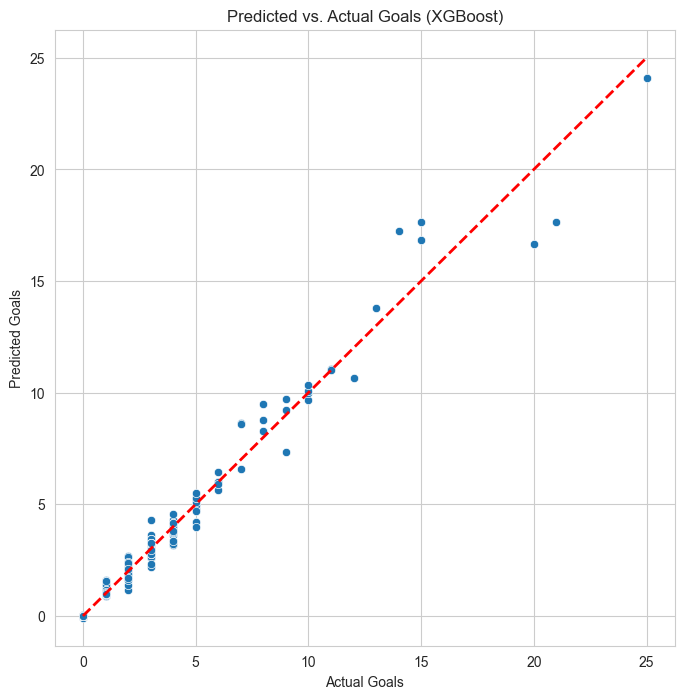

Prediction plot saved to visualizations\performance_analysis\top_scorer_pred_vs_actual.png


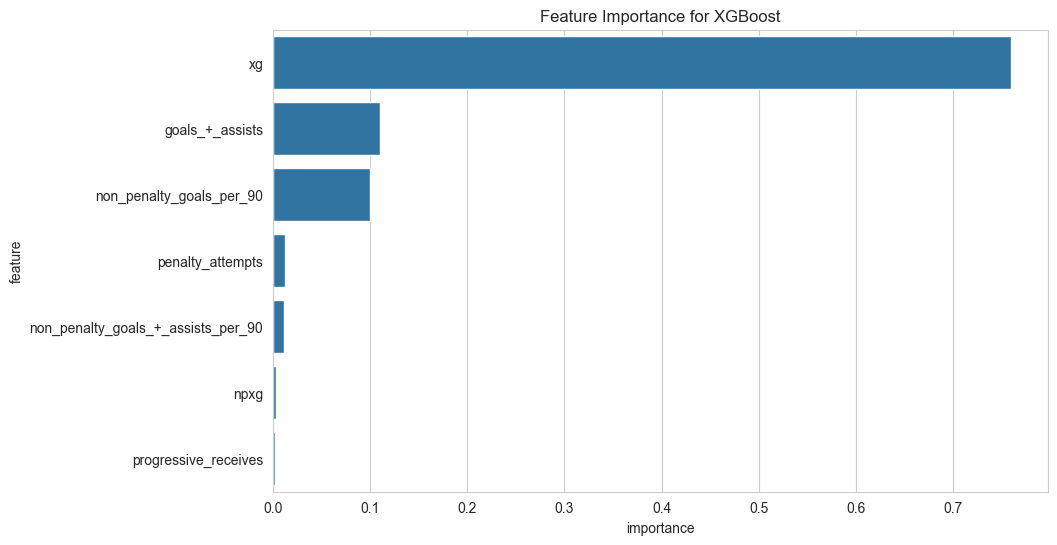

Feature importance plot saved to visualizations\performance_analysis\top_scorer_feature_importance.png

Top Scorer model and metadata saved.


In [5]:
# ==================================================
# Cell 5: Model Training and Evaluation (Top Scorer)
# ==================================================
if df_scorer is not None:
    TARGET_COL = 'goals'
    features = [c for c in df_scorer.columns if c != TARGET_COL]
    X = df_scorer[features]
    y = df_scorer[TARGET_COL]
    
    print(f"\nTraining Top Scorer model with {len(features)} features: {features}")
    print(f"Missing cells at training time (handled via SimpleImputer): {int(X.isnull().sum().sum())}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models = {'Ridge': Ridge(random_state=42), 'RandomForest': RandomForestRegressor(random_state=42)}
    if XGB_AVAILABLE: models['XGBoost'] = xgb.XGBRegressor(random_state=42)
    if LGB_AVAILABLE: models['LightGBM'] = lgb.LGBMRegressor(random_state=42, verbose=-1)
    
    param_grids = {
        'Ridge': {'model__alpha': [1.0, 10.0, 50.0]},
        'RandomForest': {'model__n_estimators': [100, 200], 'model__max_depth': [10, 20]},
        'XGBoost': {'model__n_estimators': [100, 200], 'model__learning_rate': [0.05, 0.1]},
        'LightGBM': {'model__n_estimators': [100, 200], 'model__num_leaves': [20, 31]}
    }
    
    training_summary = []
    best_model_data = None
    best_mae = float('inf')
    
    for name, model in models.items():
        print(f"--- Training {name} for Top Scorer ---")
        pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler()), ('model', model)])
        search = RandomizedSearchCV(pipeline, param_grids[name], n_iter=5, cv=KFold(5, shuffle=True, random_state=42), scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42)
        search.fit(X_train, y_train)
        y_pred = search.predict(X_test)
        
        stats = {
            'Model': name,
            'Test MAE': mean_absolute_error(y_test, y_pred),
            'Test MSE': mean_squared_error(y_test, y_pred),
            'Test R-squared': r2_score(y_test, y_pred)
        }
        training_summary.append(stats)
        print(f"  Test MAE: {stats['Test MAE']:.4f} | Test R-squared: {stats['Test R-squared']:.4f}")
        
        if stats['Test MAE'] < best_mae:
            best_mae = stats['Test MAE']
            best_model_data = {'name': name, 'model': search.best_estimator_, 'metrics': stats, 'predictions': y_pred}
    
    summary_df = pd.DataFrame(training_summary)
    print("\n--- Top Scorer Model Training Summary ---")
    display(summary_df.sort_values(by='Test MAE'))
    
    print(f"\n--- Best Model Analysis: {best_model_data['name']} ---")
    
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_test, y=best_model_data['predictions'])
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f'Predicted vs. Actual Goals ({best_model_data["name"]})')
    plt.xlabel('Actual Goals')
    plt.ylabel('Predicted Goals')
    viz_path = VIZ_DIR / 'top_scorer_pred_vs_actual.png'
    plt.savefig(viz_path)
    plt.show()
    print(f"Prediction plot saved to {viz_path}")
    
    best_model_step = best_model_data['model'].named_steps['model']
    if hasattr(best_model_step, 'feature_importances_'):
        importances = best_model_step.feature_importances_
        feature_imp_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending=False)
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_imp_df)
        plt.title(f'Feature Importance for {best_model_data["name"]}')
        fi_path = VIZ_DIR / 'top_scorer_feature_importance.png'
        plt.savefig(fi_path)
        plt.show()
        print(f"Feature importance plot saved to {fi_path}")
    
    joblib.dump(best_model_data['model'], MODELS_DIR / 'ps4_top_scorer_best_model.joblib')
    with open(MODELS_DIR / 'ps4_top_scorer_metadata.json', 'w') as f:
        json.dump({k: v for k, v in best_model_data.items() if k not in ['model', 'predictions']}, f, indent=2)
    print("\nTop Scorer model and metadata saved.")
else:
    print("Skipping Top Scorer training.")